<a href="https://colab.research.google.com/github/MarinaWolters/Coding-Tracker/blob/master/W9_Supervised_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Supervised Machine Learning

We'll next consider **supervised** machine learning, which learns a function from input features to output classes.

## 3.1 Classification via Decision Trees

We will start with perhaps the simplest (certainly, most explainable) classification algorithm, the *decision tree*.  We'll begin with a very simple example from the slides.

[Text(200.88000000000002, 181.2, 'X[0] <= 0.5\nentropy = 0.971\nsamples = 5\nvalue = [2, 3]'),
 Text(133.92000000000002, 108.72, 'X[2] <= 0.5\nentropy = 0.918\nsamples = 3\nvalue = [2, 1]'),
 Text(66.96000000000001, 36.23999999999998, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(200.88000000000002, 36.23999999999998, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(267.84000000000003, 108.72, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]')]

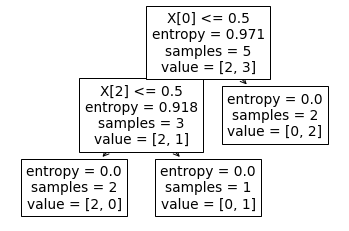

In [ ]:
from sklearn import tree
import numpy

# Here's a simple example...  We have 4
# features to predict whether someone is
# going to buy a pet.
X = numpy.array(\
                [[1,0,0,0],\
                 [0,1,1,1],\
                 [0,1,0,0],\
                 [0,0,0,1],\
                 [1,1,0,0]])
# Here is whether they bought the toy
y = [1,1,0,0,1]

clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X, y)

tree.plot_tree(clf)


### 3.1.1 Entropy

A common way of measuring the *information gain* when considering a split is through the notion of *entropy*.

Let's start with an example -- suppose we are trying to predict which students like statistics...

In [ ]:
import pandas as pd

input_data = pd.DataFrame([{'major': 'math','likes_stats': False},\
                           {'major': 'math','likes_stats': False},\
                           {'major': 'math','likes_stats': True},\
                           {'major': 'math','likes_stats': True},\
                           {'major': 'engl','likes_stats': False},\
                           {'major': 'stat','likes_stats': True},\
                           {'major': 'stat','likes_stats': True},\
                           {'major': 'engl','likes_stats': False},\
                           ])

input_data

,major,likes_stats
0,math,False
1,math,False
2,math,True
3,math,True
4,engl,False
5,stat,True
6,stat,True
7,engl,False


In [ ]:
from math import log2

def prob(term):
  return len(input_data[input_data['major']==term])/len(input_data)

# Here's how to compute the entropy for the dataset
majors = set(input_data['major'])
probs = {}
for major in majors:
  probs[major] = prob(major)

print (probs)

entropy_major = -sum([p * log2(p) for p in probs.values()])
print('Entropy of major: %.2f'%entropy_major)

### Here's built-in Python support...
from scipy.stats import entropy

print ('Entropy of likes_stats: %0.2f'%entropy(\
    [len(input_data[input_data['likes_stats']==True])/len(input_data),
     len(input_data[input_data['likes_stats']==False])/len(input_data)],base=2))

{'engl': 0.25, 'stat': 0.25, 'math': 0.5}
Entropy of major: 1.50
Entropy of major: 1.50
Entropy of likes_stats: 1.00


Now let's consider *conditional entropy*... Specifically, the entropy of whether someone likes stats, given their major.

In [ ]:
def get_subset_likes_stats(term):
  subset = input_data[input_data['major']==term]['likes_stats']
  return [sum(subset==False)/len(subset), sum(subset==True)/len(subset)]

subsets = {}
for major in majors:
  subsets[major] = get_subset_likes_stats(major)
  print(probs[major],'* entropy(',subsets[major],')')

entropy_likes_stats_given_major = sum([probs[major] * \
                                       entropy(subsets[major],base=2) \
                                        for major in probs.keys()])

entropy_likes_stats_given_major

0.25 * entropy( [1.0, 0.0] )
0.25 * entropy( [0.0, 1.0] )
0.5 * entropy( [0.5, 0.5] )


0.5

Conditional entropy is ultimately useful for measuring information gain, e.g., the Information Gain $IG(likes\_stats | major)$ is equal to $H(likes\_stats) - H(likes\_stats|major)$, which is equal to $1.0 - 0.5$.

### 3.1.2 Decision Trees for Real Data

In [ ]:
from sklearn.datasets import load_wine

dataset = load_wine()
dataset.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [ ]:
# Here is the table as a dataframe
pd.DataFrame(dataset.data,columns=dataset.feature_names)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [ ]:
# These are the y vector -- the target class (0, 1, 2)
dataset.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [ ]:
from sklearn.model_selection import train_test_split
import sklearn.metrics

X_train, X_test, y_train, y_test = train_test_split(dataset.data, \
                                                    dataset.target, \
                                                    test_size=0.30)


In [ ]:
# Training step, on X_train with y_train
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train,y_train)

# Prediction step, with X_test (and we will validate accuracy
# against y_test)
prediction = clf.predict(X_test)

# Test accuracy, ie Jaccard distance of matched items
accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 90.7%


[Text(845.4545454545455, 1087.2, 'X[11] <= 2.09\nentropy = 1.563\nsamples = 124\nvalue = [43, 49, 32]'),
 Text(507.27272727272725, 845.6, 'X[6] <= 1.4\nentropy = 0.503\nsamples = 36\nvalue = [0, 4, 32]'),
 Text(338.1818181818182, 604.0, 'X[9] <= 3.525\nentropy = 0.196\nsamples = 33\nvalue = [0, 1, 32]'),
 Text(169.0909090909091, 362.4, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(507.27272727272725, 362.4, 'entropy = 0.0\nsamples = 32\nvalue = [0, 0, 32]'),
 Text(676.3636363636364, 604.0, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3, 0]'),
 Text(1183.6363636363637, 845.6, 'X[0] <= 12.81\nentropy = 1.0\nsamples = 88\nvalue = [43, 45, 0]'),
 Text(1014.5454545454545, 604.0, 'entropy = 0.0\nsamples = 41\nvalue = [0, 41, 0]'),
 Text(1352.7272727272727, 604.0, 'X[12] <= 655.0\nentropy = 0.42\nsamples = 47\nvalue = [43, 4, 0]'),
 Text(1183.6363636363637, 362.4, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3, 0]'),
 Text(1521.8181818181818, 362.4, 'X[10] <= 1.295\nentropy = 0.156\nsamples

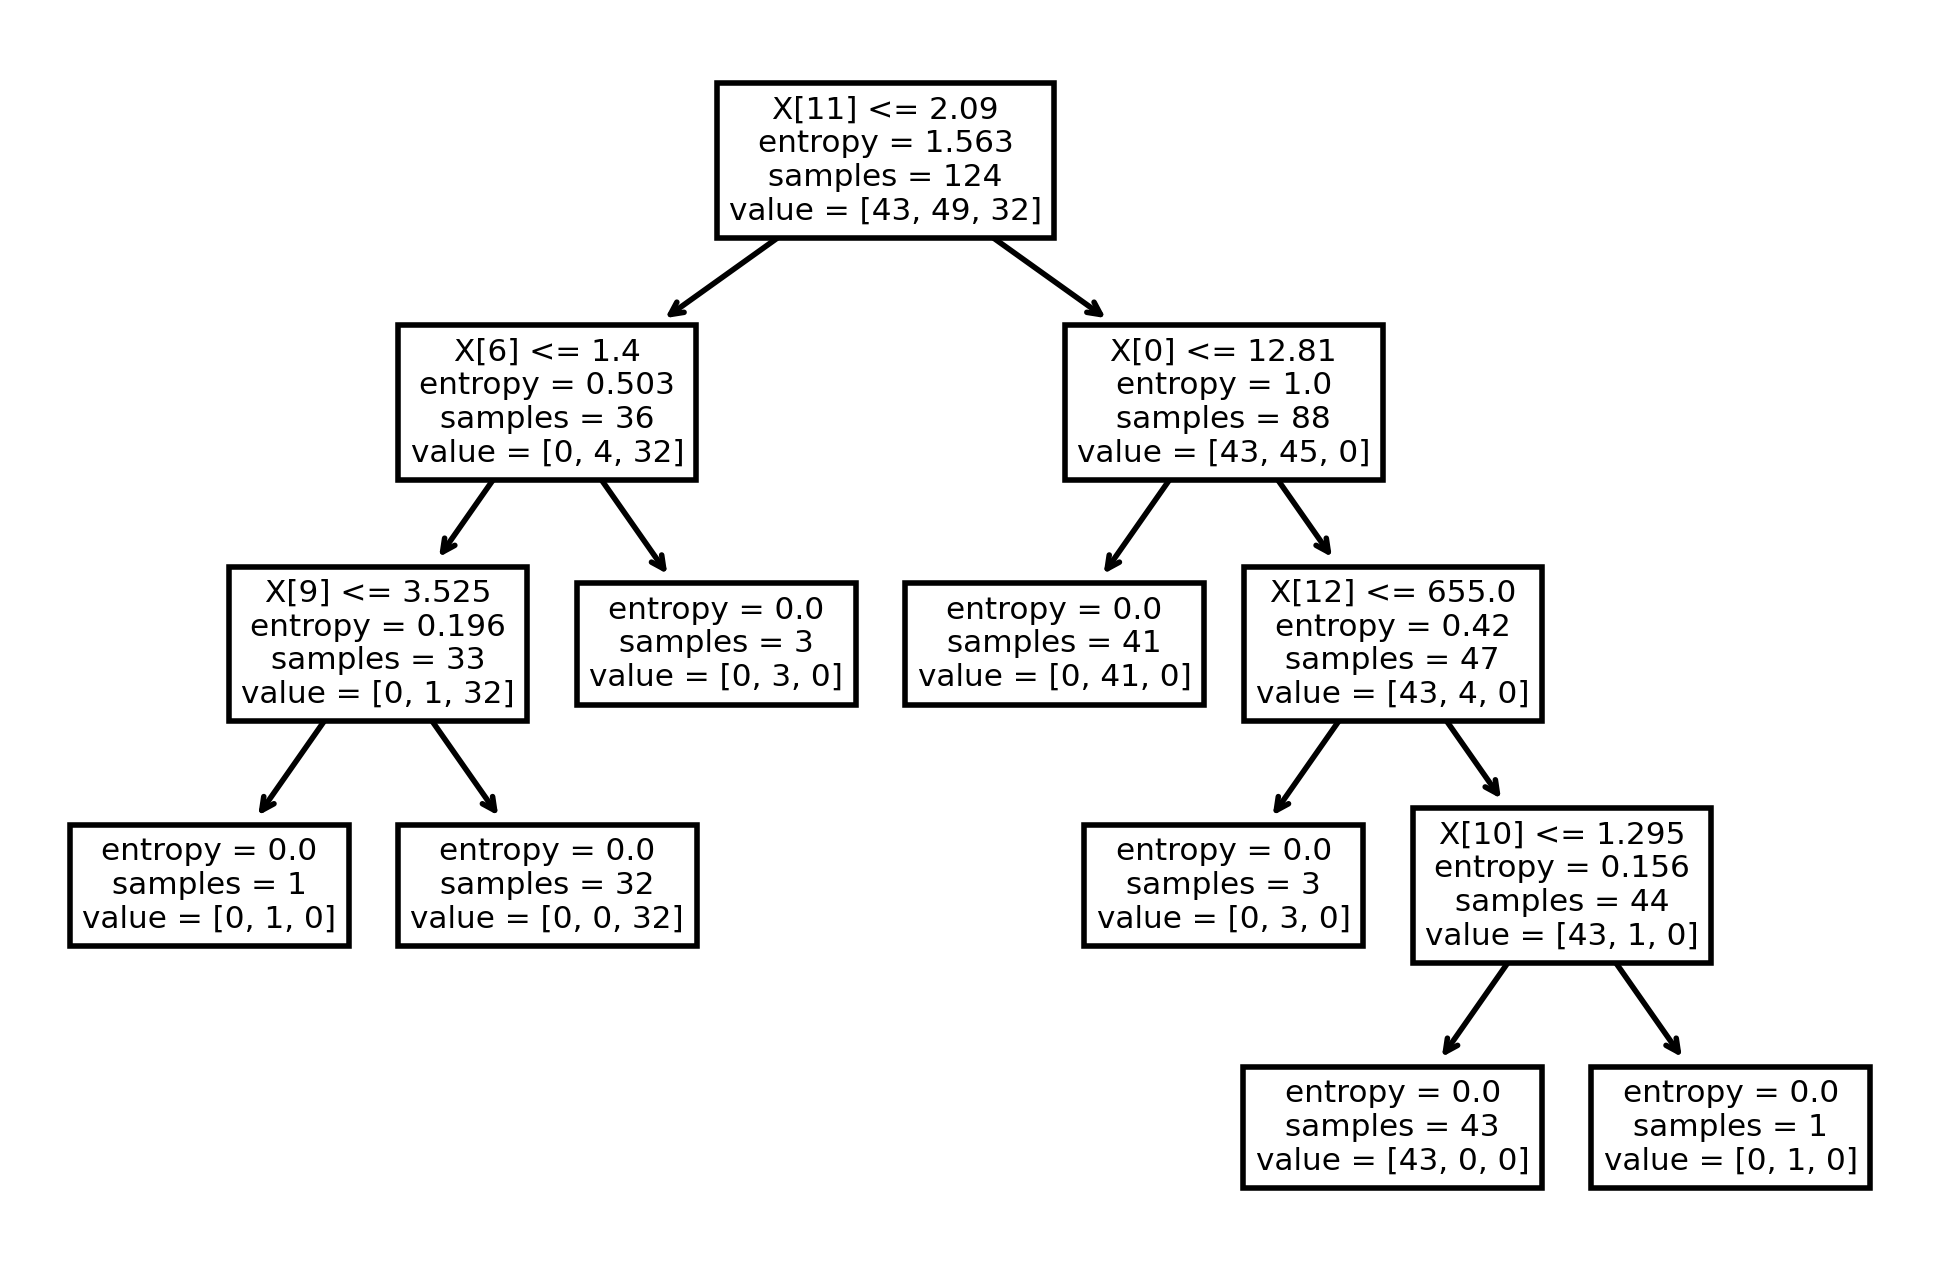

In [ ]:
from matplotlib import pyplot as plt

plt.figure(dpi=400)
tree.plot_tree(clf)

### 3.1.3 Decision Trees at Scale: Spark MLLib

Now let's see how to use the MLlib library to train a classifier.

In [ ]:
!apt install libkrb5-dev
!pip install sparkmagic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  comerr-dev krb5-multidev libcom-err2 libgssrpc4 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
The following packages will be upgraded:
  libcom-err2
1 upgraded, 7 newly installed, 0 to remove and 24 not upgraded.
Need to get 358 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcom-err2 amd64 1.44.1-1ubuntu1.3 [8,848 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.1 [54.2 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.1 [37.2 kB]
Get:4 http

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
%spark add -s my_session -l python -u http://ec2-3-91-74-45.compute-1.amazonaws.com:8998
# The above can connect to an EMR node running Spark + Livy, assuming the firewall is set to let anyone in

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
81,application_1581350900124_0082,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [ ]:
%%spark

import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import StringType, IntegerType, DoubleType, StructField, StructType, ArrayType, MapType

dataset = load_wine()
# ID,RefractiveIndex,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
schema = StructType([
        StructField("alcohol", DoubleType(), True),
        StructField("malic_acid", DoubleType(), True),
        StructField("ash", DoubleType(), True),
        StructField("alcalinity_of_ash", DoubleType(), True),
        StructField("magnesium", DoubleType(), True),
        StructField("total_phenols", DoubleType(), True),
        StructField("flavanoids", DoubleType(), True),
        StructField("nonflavanoid_phenols", DoubleType(), True),
        StructField("proanthocyanins", DoubleType(), True),
        StructField("color_intensity", DoubleType(), True),
        StructField("hue", DoubleType(), True),
        StructField("od280/od315_of_diluted_wines", DoubleType(), True),
        StructField("proline", DoubleType(), True),
        StructField("label", IntegerType(), True),
         ])

### For simplicity we are only going to do a binary classifier
### to determine if we have class 1
pdf = pd.DataFrame(dataset.data)
pdf['label'] = [1 if x == 1 else 0 for x in dataset.target]
print(pdf)
wine_sdf = spark.createDataFrame(pdf, schema)

# Recall from unsupervised learning that the assembler cconverts a list of
# dataframe columns into a "features" column that's a vector
assembler = VectorAssembler(inputCols=dataset.feature_names, outputCol="features")
wine_sdf_2 = assembler.transform(wine_sdf)

wine_sdf_2.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         0     1     2     3      4  ...      9    10    11      12  label
0    14.23  1.71  2.43  15.6  127.0  ...   5.64  1.04  3.92  1065.0      0
1    13.20  1.78  2.14  11.2  100.0  ...   4.38  1.05  3.40  1050.0      0
2    13.16  2.36  2.67  18.6  101.0  ...   5.68  1.03  3.17  1185.0      0
3    14.37  1.95  2.50  16.8  113.0  ...   7.80  0.86  3.45  1480.0      0
4    13.24  2.59  2.87  21.0  118.0  ...   4.32  1.04  2.93   735.0      0
..     ...   ...   ...   ...    ...  ...    ...   ...   ...     ...    ...
173  13.71  5.65  2.45  20.5   95.0  ...   7.70  0.64  1.74   740.0      0
174  13.40  3.91  2.48  23.0  102.0  ...   7.30  0.70  1.56   750.0      0
175  13.27  4.28  2.26  20.0  120.0  ...  10.20  0.59  1.56   835.0      0
176  13.17  2.59  2.37  20.0  120.0  ...   9.30  0.60  1.62   840.0      0
177  14.13  4.10  2.74  24.5   96.0  ...   9.20  0.61  1.60   560.0      0

[178 rows x 14 columns]
+-------+----------+----+-----------------+---------+-------------+--------

Now we split into training and test sets and train...

In [ ]:
%%spark

train, test = wine_sdf_2.randomSplit([0.7, 0.3], seed = 2018)

from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark


from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Area Under ROC: 0.942929292929293

### 3.1.3 Random Forests

A random forest generalizes the decision tree using an ensemble.  We can define both the pruning characteristics for the decision trees plus the size of the ensemble in SciKit-Learn

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 20, max_depth=2)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 96.3%


and similarly, Mllib has a random forest classifier.  In fact the RandomForestClassifier parallelizes very nicely since each tree can be running independently of the others.

In [ ]:
%%spark

from pyspark.ml.classification import RandomForestClassifier
dt = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 2,\
                            numTrees = 20)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Area Under ROC: 0.9919191919191919